In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm


sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import datetime
print(datetime.datetime.now())

2020-09-03 15:47:51.811229


In [4]:
resolution = 100

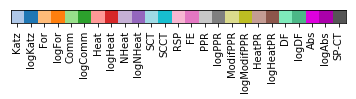

In [5]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

In [6]:
def create_krondecker(partition):
    n = len(partition)
    kron_mask = np.tile(partition, n) == np.repeat(partition, n)

    return np.reshape(kron_mask, (n, n))


def modularity2(AIJ, partition):
    n = len(AIJ)
    m = np.sum(AIJ)  # no of edges

    k = np.sum(AIJ, axis=1)
    expectation = np.reshape(np.tile(k, n) * np.repeat(k, n), (n, n)) / m
    kron = create_krondecker(partition)

    # Q = (1 / 2m) * SUM(AIJ - (ki.kj / 2m)) ∂(ci, cj)
    return (1.0 / m) * np.sum(kron * (AIJ - expectation))

In [7]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())


def estimate_mu(graph, partition):
    n_out_edges = 0
    n_nodes = graph.size()
    for n1, n2 in graph.edges():  # links:
        if partition[n1] != partition[n2]:
            n_out_edges += 1
    return n_out_edges / n_nodes


def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau


def modularity(A: np.array, partition):
    """
    Simplified version only for undirected graphs
    """
    n_stubs = np.sum(A)
    deg = np.sum(A, axis=1, keepdims=True)

    Q_items = A - np.diagonal(np.diagonal(A)) - deg.dot(deg.T) / n_stubs
    Q = 0
    for class_name in set(partition):
        mask = np.array(partition) == class_name
        Q += np.sum(Q_items[mask][:, mask])
    return Q / n_stubs


def redetect_params(data):
    A, partition = data['A'], data['y_true']
    G = np2nx(A, partition)
    
    n = G.number_of_nodes()
    average_degree = 2 * G.number_of_edges() / n
    node_degrees = [d for n, d in G.degree()]
    min_degree = np.min(node_degrees)
    max_degree = np.max(node_degrees)
    tau1 = power_law(node_degrees, 250)
    modularity = nx_modularity(G, partition2communities(partition))

    # Community-based parameters
    k = len(set(partition))
    mu = min(max(estimate_mu(G, partition), 0.), 1.)
    community_sizes = list(Counter(partition).values())
    min_community = np.min(community_sizes)
    max_community = np.max(community_sizes)
    tau2 = power_law(community_sizes, 250)
    
    return {
        'n': n,
        'k': k,
        'average_degree': average_degree,
        'min_degree': min_degree, 
        'max_degree': max_degree,
        'tau1': tau1,
        'mu': mu,
        'min_community': min_community,
        'max_community': max_community,
        'tau2': tau2,
        'modularity': modularity
    }

In [43]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'
    
def perform_one(fn):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
    need_to_save = False
    A = data['A']
    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                if 'new_modularity2' not in parameter_results[0]:  # add new_modularity if not exist
                    for init_idx, init in enumerate(parameter_results):
                        partition = init['labels']
                        init['new_modularity2'] = modularity2(A, partition)
                    need_to_save = True
                param_best_ari = sorted(parameter_results, key=lambda x: -x['new_modularity2'])[0]['score_ari']
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
        item[kernel_name] = kernel_best_ari
    
    if need_to_save:
        with open(f'{root}/{fn}', 'wb') as f:
            pickle.dump(data, f)
    
    return item, redetect_params(data)

dataset = Parallel(n_jobs=12)(delayed(perform_one)(fn) for fn in tqdm(os.listdir(root)))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [44]:
# generate additional features
for item in dataset:
    maxari = np.max(list(item[0].values()))
    item[1]['maxari'] = maxari
    item[1]['average_degree/n'] = item[1]['average_degree'] / item[1]['n']
    item[1]['min_community/max_community'] = item[1]['min_community'] / item[1]['max_community']
    item[1]['min_degree/max_degree'] = item[1]['min_degree'] / item[1]['max_degree']
    item[1]['mu/(average_degree/n)'] = item[1]['mu'] / (item[1]['average_degree'] / item[1]['n'])

In [45]:
dataset[0]

({'Katz': 0.1429144148835836,
  'logKatz': 0.4409365359200871,
  'For': 0.011806037718625746,
  'logFor': 0.31984318212926616,
  'Comm': 0.16101858587315618,
  'logComm': 0.3654948835662535,
  'Heat': 0.008029119101342626,
  'logHeat': 0.09278927135814646,
  'NHeat': 0.3426004146382099,
  'logNHeat': 0.42626930796187673,
  'SCT': 0.6402286022746339,
  'SCCT': 0.6723689518427769,
  'RSP': 0.578839306718301,
  'FE': 0.4361064096048135,
  'PPR': 0.021378616857131837,
  'logPPR': 0.4282238544368487,
  'ModifPPR': 0.0018484419692191478,
  'logModifPPR': 0.4282238544368487,
  'HeatPR': 0.41810265887494713,
  'logHeatPR': 0.42626930796187673,
  'DF': 0.1429144148835836,
  'logDF': 0.005508380245445584,
  'Abs': 0.033755033080549994,
  'logAbs': 0.49289815801917974,
  'SP-CT': 0.5537528493741254},
 {'n': 1372,
  'k': 6,
  'average_degree': 262.3250728862974,
  'min_degree': 146,
  'max_degree': 1023,
  'tau1': 6.0327809625039075,
  'mu': 0.7097441026923398,
  'min_community': 147,
  'max_commu

In [46]:
ctr = Counter()
win_len_ctr = Counter()
maxari1 = 0
for item in dataset:
    item_maxari = np.max(list(item[0].values()))
    if item_maxari == 1:
        continue
    item_won_measures = [name for name, ari in item[0].items() if ari == item_maxari]
    if 'SCCT' in item_won_measures or 'NHeat' in item_won_measures or 'Comm' in item_won_measures or 'logComm' in item_won_measures:
#        'RSP' in item_won_measures or  or 'SCT' in item_won_measures or \
#        'SP-CT' in item_won_measures or 'logDF' in item_won_measures or 'logKatz' in item_won_measures or \
#        'logHeatPR' in item_won_measures or 'logPPR' in item_won_measures or 'Katz' in item_won_measures or \
#        'logHeat' in item_won_measures or 'Abs' in item_won_measures or 'Heat' in item_won_measures or \
#        'DF' in item_won_measures or 'logModifPPR' in item_won_measures or 'FE' in item_won_measures or \
#        'logFor' in item_won_measures or 'HeatPR' in item_won_measures or 'For' in item_won_measures or \
#        'PPR' in item_won_measures or 'logNHeat' in item_won_measures or 'logAbs' in item_won_measures:
        continue
    win_len_ctr[len(item_won_measures)] += 1
    if item_maxari == 1:
        maxari1 += 1
    for item_won_measure in item_won_measures:
        ctr[item_won_measure] += 1
ctr.most_common(30)

[('RSP', 45),
 ('SCT', 38),
 ('SP-CT', 36),
 ('logKatz', 25),
 ('logDF', 21),
 ('logPPR', 16),
 ('logModifPPR', 16),
 ('logHeatPR', 16),
 ('Abs', 14),
 ('logNHeat', 14),
 ('FE', 12),
 ('Katz', 11),
 ('Heat', 10),
 ('logHeat', 9),
 ('DF', 7),
 ('logFor', 6),
 ('HeatPR', 5),
 ('logAbs', 5),
 ('For', 3),
 ('ModifPPR', 2),
 ('PPR', 2)]

In [47]:
win_len_ctr.most_common(30)

[(1, 213), (2, 22), (3, 5), (4, 2), (5, 2), (9, 1), (6, 1), (8, 1)]

In [48]:
maxari1

0

# My own knn

In [49]:
def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
#     assert X.shape[1:] == Y.shape[1:], f'{X.shape}, {Y.shape}'
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
#     assert result.shape[0] == X.shape[0] and result.shape[1] == Y.shape[0], result.shape
    return result

In [50]:
class MyKNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = np.argsort(pair_distance[test_idx])[:self.n_neighbors]
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)
    
    
class MyFilter:
    def __init__(self, distance=0.05):
        self.max_distance = distance
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < self.max_distance:
                    chosen_indices.append(train_idx)
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx] * (self.max_distance - pair_distance[test_idx, chosen_idx])
            output.append(weighted_results)
        return np.array(output)
    
    
class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            if len(chosen_indices) < 3:
                chosen_indices = []
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            sum_weights = np.sum([gaussian_weights[test_idx, chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
        return np.array(output)

# Plot knn of two features

In [51]:
all_feature_names = [
    'n',
    'k',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
    'min_community',
    'maxari',
    'modularity',
    'average_degree/n',
    'min_community/max_community',
    'min_degree/max_degree',
    'mu/(average_degree/n)'
]

fnc = {
    'n': lambda x: x/1500,
    'k': lambda x: ((1 - 1/x) - 0.5) * 2,
#     'tau1': lambda x: ((np.log(x) - 0.7) / 3.6),
#     'tau2': lambda x: ((np.log(x) - 0.4) / 5),
    'tau1': lambda x: 1 - (1 / x**0.5),
    'tau2': lambda x: 1 - (1 / x**0.5),
    'mu': lambda x: x,
    'average_degree': lambda x: x/850,
    'min_community': lambda x: x/750,
    'maxari': lambda x: x,
    'modularity': lambda x: (x + 0.5) * 0.75,
    'average_degree/n': lambda x: x / 0.7,
    'min_community/max_community': lambda x: x,
    'min_degree/max_degree': lambda x: x / 0.7,
    'mu/(average_degree/n)': lambda x: x ** 0.25 / 4
}

In [52]:
real_limits = {}
limits = {}
for fname in all_feature_names:
    min_max = np.min([info[fname] for _, info in dataset]), np.max([info[fname] for _, info in dataset])
    real_limits[fname] = min_max
    limits[fname] = fnc[fname](min_max[0]), fnc[fname](min_max[1])
    print(f'{fname}: {real_limits[fname][0]:.2f}, {real_limits[fname][1]:.2f} | {limits[fname][0]:.2f}, {limits[fname][1]:.2f}')
  
# real_limits['tau1'] = (1, 200)
# real_limits['tau2'] = (1, 200)
# limits['tau1'] = (0, 0.99)
# limits['tau2'] = (0, 0.99)
    
def point2plot(x, feature_name):
    vmin, vmax = limits[feature_name]
    return (x - vmin) / (vmax - vmin) * resolution

n: 10.00, 1499.00 | 0.01, 1.00
k: 2.00, 224.00 | 0.00, 0.99
tau1: 1.96, 235.90 | 0.28, 0.93
tau2: 1.51, 250.00 | 0.19, 0.94
mu: 0.00, 1.00 | 0.00, 1.00
average_degree: 1.17, 940.53 | 0.00, 1.11
min_community: 1.00, 729.00 | 0.00, 0.97
maxari: 0.00, 1.00 | 0.00, 1.00
modularity: -0.49, 0.95 | 0.01, 1.09
average_degree/n: 0.00, 0.80 | 0.01, 1.15
min_community/max_community: 0.02, 1.00 | 0.02, 1.00
min_degree/max_degree: 0.00, 0.80 | 0.00, 1.14
mu/(average_degree/n): 0.00, 232.24 | 0.05, 0.98


In [53]:
kernels_order = [x.name for x in kernels]
kernels_order

['Katz',
 'logKatz',
 'For',
 'logFor',
 'Comm',
 'logComm',
 'Heat',
 'logHeat',
 'NHeat',
 'logNHeat',
 'SCT',
 'SCCT',
 'RSP',
 'FE',
 'PPR',
 'logPPR',
 'ModifPPR',
 'logModifPPR',
 'HeatPR',
 'logHeatPR',
 'DF',
 'logDF',
 'Abs',
 'logAbs',
 'SP-CT']

In [54]:
def prepare_plot_knn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([sorted(item[0].items(), key=lambda x: -x[1])[0][0] for item in dataset])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_myknn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyKNN(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
#             pixels_kernels_results[11] = 0
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

In [55]:
def doplot(ax, X, y, plot, feature_names, scatter=True):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2 
    ax.set_xticks(np.linspace(0, resolution, n_ticks))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[1]][0], real_limits[feature_names[1]][1], n_ticks)], rotation='vertical');
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2 
    ax.set_yticks(np.linspace(0, resolution, n_ticks))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[0]][0], real_limits[feature_names[0]][1], n_ticks)]);
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution)

    if scatter:
        ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=1, c='black')

In [56]:
def prepare_field_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)
    
    arr = np.zeros([resolution] * len(feature_names) + [y.shape[1]], dtype=np.float32)
    plot = np.zeros([resolution] * len(feature_names) + [3], dtype=np.uint8)
    params_spaces = [np.linspace(limits[fname][0], limits[fname][1], resolution) for fname in feature_names]
    print(params_spaces)
    for point in tqdm(product(*[range(resolution) for _ in range(len(feature_names))]), total=resolution ** len(feature_names)):
        params = [params_spaces[i][point[i]] for i in range(len(feature_names))]
        pixels_kernels_results = knn.predict([params])[0]
        arr[point] = pixels_kernels_results
        
        if ~np.all(pixels_kernels_results == 0):
            pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
            plot[point] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
        else:
            plot[point] = np.array([1, 1, 1]) * 255
    
    return X, y, arr, plot

In [57]:
dataset[0]

({'Katz': 0.1429144148835836,
  'logKatz': 0.4409365359200871,
  'For': 0.011806037718625746,
  'logFor': 0.31984318212926616,
  'Comm': 0.16101858587315618,
  'logComm': 0.3654948835662535,
  'Heat': 0.008029119101342626,
  'logHeat': 0.09278927135814646,
  'NHeat': 0.3426004146382099,
  'logNHeat': 0.42626930796187673,
  'SCT': 0.6402286022746339,
  'SCCT': 0.6723689518427769,
  'RSP': 0.578839306718301,
  'FE': 0.4361064096048135,
  'PPR': 0.021378616857131837,
  'logPPR': 0.4282238544368487,
  'ModifPPR': 0.0018484419692191478,
  'logModifPPR': 0.4282238544368487,
  'HeatPR': 0.41810265887494713,
  'logHeatPR': 0.42626930796187673,
  'DF': 0.1429144148835836,
  'logDF': 0.005508380245445584,
  'Abs': 0.033755033080549994,
  'logAbs': 0.49289815801917974,
  'SP-CT': 0.5537528493741254},
 {'n': 1372,
  'k': 6,
  'average_degree': 262.3250728862974,
  'min_degree': 146,
  'max_degree': 1023,
  'tau1': 6.0327809625039075,
  'mu': 0.7097441026923398,
  'min_community': 147,
  'max_commu

In [67]:
top6 = ['SCCT', 'NHeat', 'logComm', 'SCT', 'RSP']
dataset_top6 = deepcopy(dataset)
for idx in range(len(dataset)):
    for measure_name in dataset_top6[idx][0].keys():
        if measure_name not in top6:
            dataset_top6[idx][0][measure_name] = 0
            
top5 = ['NHeat', 'logComm', 'SCT', 'RSP']
dataset_top5 = deepcopy(dataset)
for idx in range(len(dataset)):
    for measure_name in dataset_top5[idx][0].keys():
        if measure_name not in top5:
            dataset_top5[idx][0][measure_name] = 0

was_deleted = True
while was_deleted:
    was_deleted = False
    for idx in range(len(dataset_top6)):
        if np.max(list(dataset_top6[idx][0].values())) == 1:
            del dataset_top6[idx]
            was_deleted = True
            break

was_deleted = True
while was_deleted:
    was_deleted = False
    for idx in range(len(dataset_top5)):
        if np.max(list(dataset_top5[idx][0].values())) == 1:
            del dataset_top5[idx]
            was_deleted = True
            break

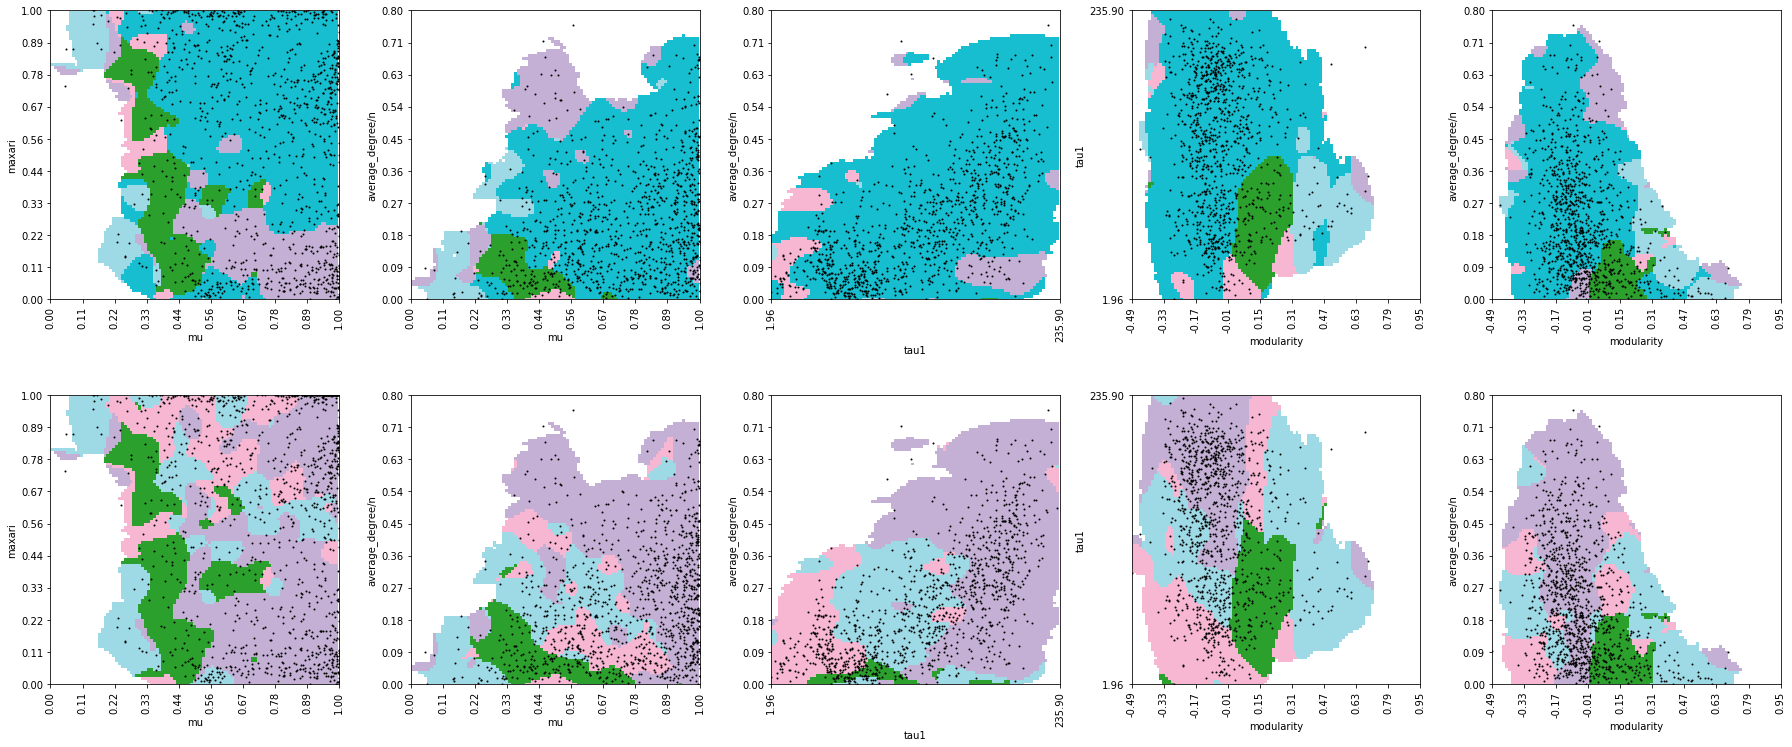

In [73]:
distance = 0.03

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'mu']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['tau1', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)


feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'mu']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['tau1', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

хочу чтобы по x была модулярность, по y -- average_degree/n, а по глубине -- tau1

(array([ 28.,  73., 126., 123.,  89., 119., 117., 164., 177.,  43.]),
 array([0.        , 0.09719124, 0.19438248, 0.29157372, 0.38876496,
        0.4859562 , 0.58314744, 0.68033868, 0.77752991, 0.87472115,
        0.97191239]),
 <a list of 10 Patch objects>)

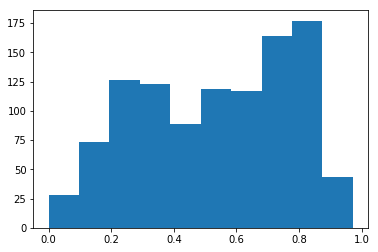

In [85]:
plt.hist([point2plot(fnc['tau1'](dataset_top5[idx][1]['tau1']), 'tau1') / resolution for idx in range(len(dataset_top6))])

In [91]:
dataset_top6_tau1_0, dataset_top6_tau1_1, dataset_top6_tau1_2, dataset_top6_tau1_3, dataset_top6_tau1_4 = [], [], [], [], []
for idx in range(len(dataset_top6)):
    tau1 = point2plot(fnc['tau1'](dataset_top6[idx][1]['tau1']), 'tau1') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top6_tau1_0.append(dataset_top6[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top6_tau1_1.append(dataset_top6[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top6_tau1_2.append(dataset_top6[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top6_tau1_3.append(dataset_top6[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top6_tau1_4.append(dataset_top6[idx])
print(len(dataset_top6_tau1_0), len(dataset_top6_tau1_1), len(dataset_top6_tau1_2), len(dataset_top6_tau1_3), len(dataset_top6_tau1_4))
        
dataset_top5_tau1_0, dataset_top5_tau1_1, dataset_top5_tau1_2, dataset_top5_tau1_3, dataset_top5_tau1_4 = [], [], [], [], []
for idx in range(len(dataset_top5)):
    tau1 = point2plot(fnc['tau1'](dataset_top5[idx][1]['tau1']), 'tau1') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top5_tau1_0.append(dataset_top5[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top5_tau1_1.append(dataset_top5[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top5_tau1_2.append(dataset_top5[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top5_tau1_3.append(dataset_top5[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top5_tau1_4.append(dataset_top5[idx])
print(len(dataset_top5_tau1_0), len(dataset_top5_tau1_1), len(dataset_top5_tau1_2), len(dataset_top5_tau1_3), len(dataset_top5_tau1_4))

121 268 226 282 162
122 276 243 327 197


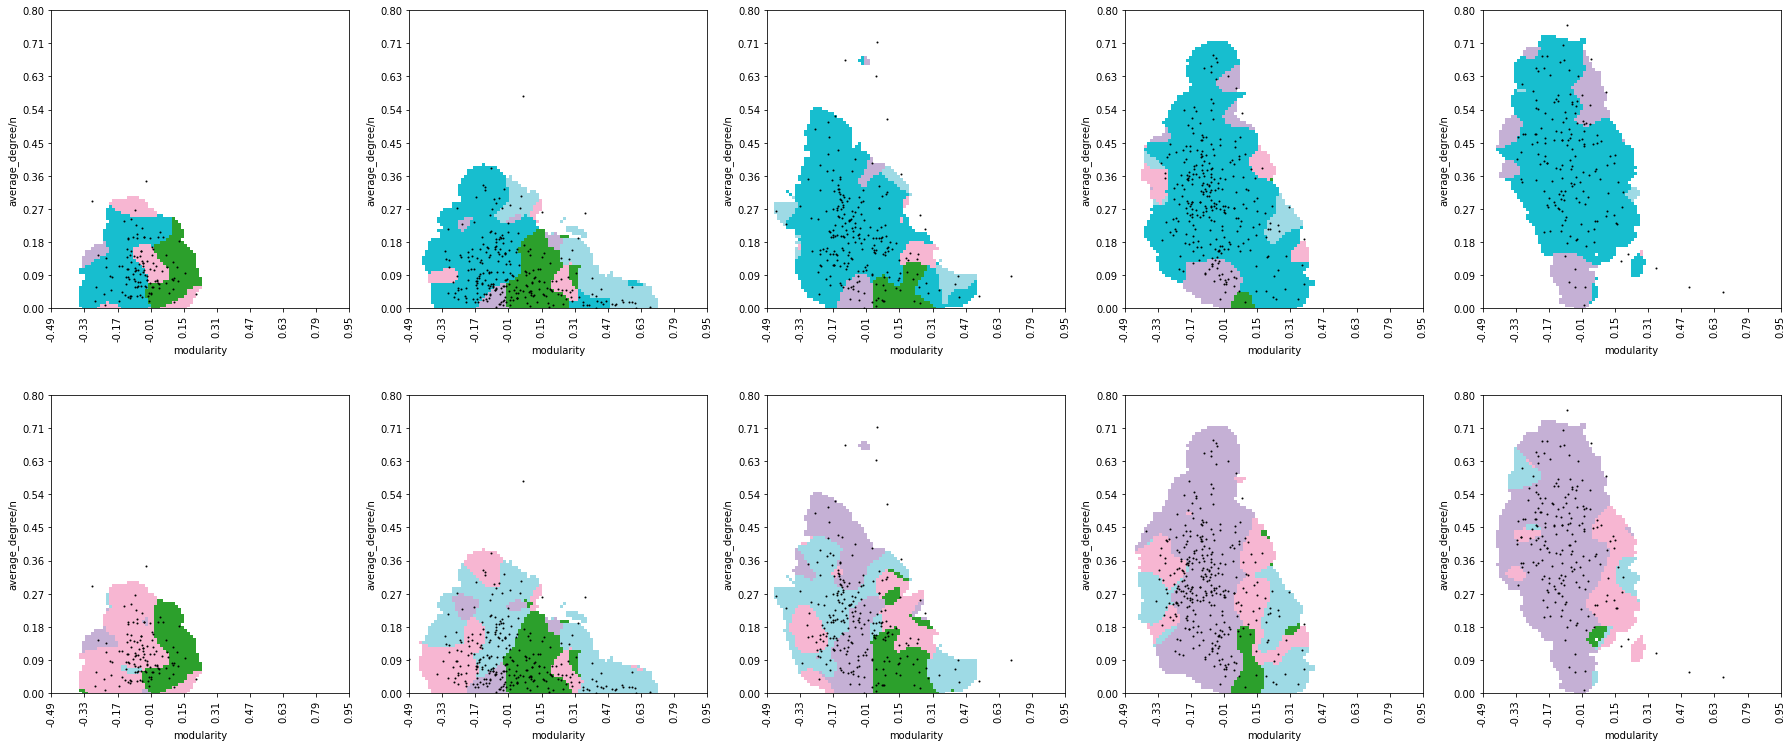

In [92]:
distance = 0.03

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6_tau1_0, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6_tau1_1, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6_tau1_2, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6_tau1_3, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6_tau1_4, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)


feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5_tau1_0, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5_tau1_1, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5_tau1_2, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5_tau1_3, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5_tau1_4, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

In [93]:
dataset_top6_modularity_0, dataset_top6_modularity_1, dataset_top6_modularity_2, dataset_top6_modularity_3, dataset_top6_modularity_4 = [], [], [], [], []
for idx in range(len(dataset_top6)):
    tau1 = point2plot(fnc['modularity'](dataset_top6[idx][1]['modularity']), 'modularity') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top6_modularity_0.append(dataset_top6[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top6_modularity_1.append(dataset_top6[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top6_modularity_2.append(dataset_top6[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top6_modularity_3.append(dataset_top6[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top6_modularity_4.append(dataset_top6[idx])
print(len(dataset_top6_modularity_0), len(dataset_top6_modularity_1), len(dataset_top6_modularity_2), len(dataset_top6_modularity_3), len(dataset_top6_modularity_4))
        
dataset_top5_modularity_0, dataset_top5_modularity_1, dataset_top5_modularity_2, dataset_top5_modularity_3, dataset_top5_modularity_4 = [], [], [], [], []
for idx in range(len(dataset_top5)):
    tau1 = point2plot(fnc['modularity'](dataset_top5[idx][1]['modularity']), 'modularity') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top5_modularity_0.append(dataset_top5[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top5_modularity_1.append(dataset_top5[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top5_modularity_2.append(dataset_top5[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top5_modularity_3.append(dataset_top5[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top5_modularity_4.append(dataset_top5[idx])
print(len(dataset_top5_modularity_0), len(dataset_top5_modularity_1), len(dataset_top5_modularity_2), len(dataset_top5_modularity_3), len(dataset_top5_modularity_4))

109 757 164 26 3
182 787 167 26 3


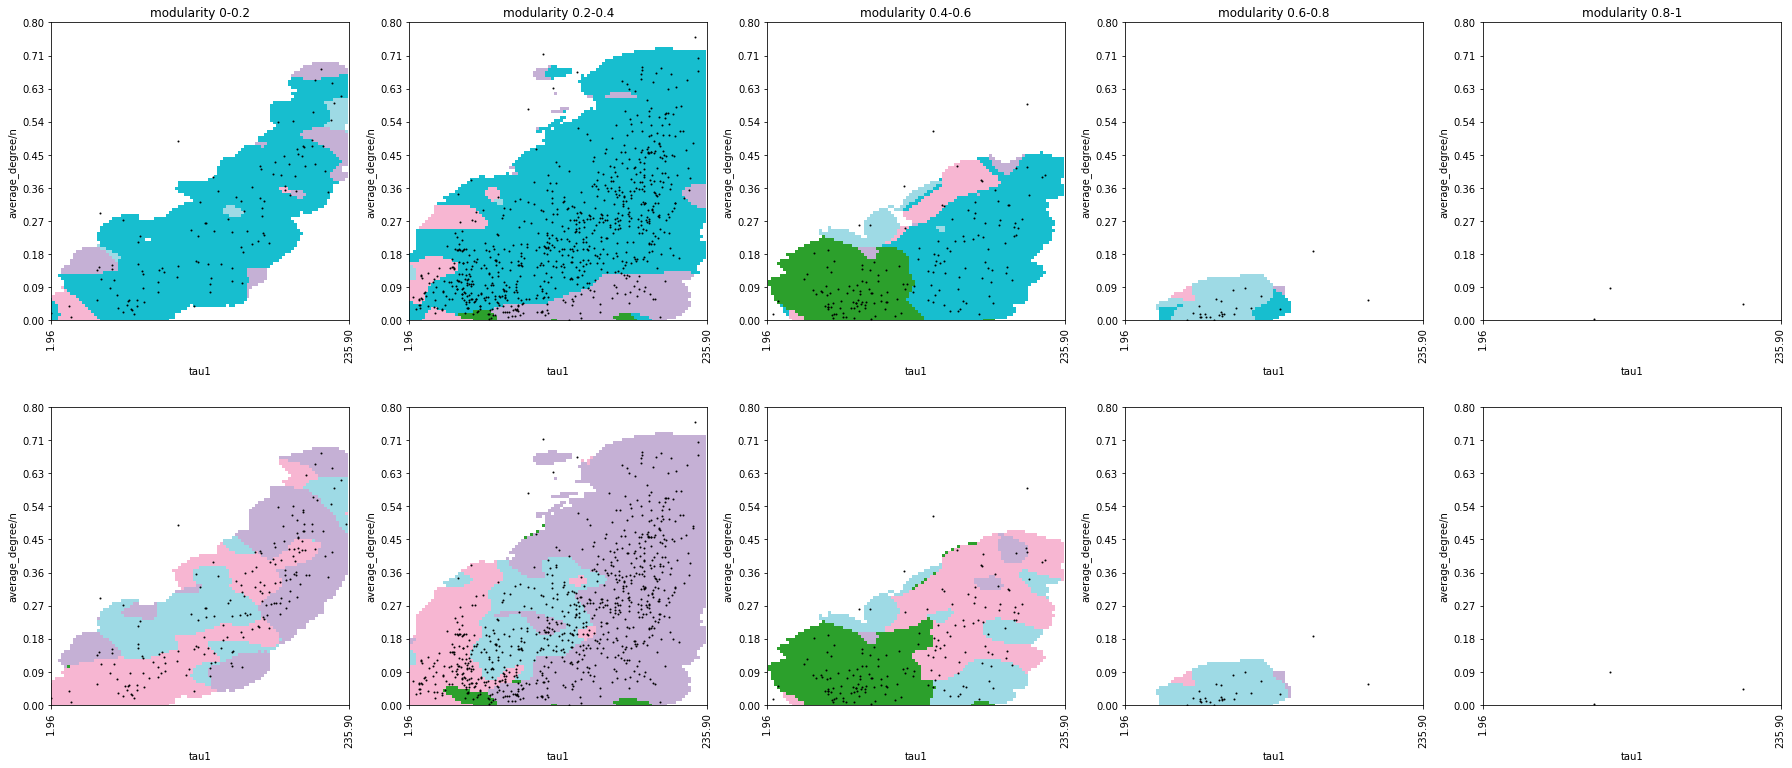

In [99]:
distance = 0.03

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_0, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)
ax[0][0].set_title('modularity 0-0.2')

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_1, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)
ax[0][1].set_title('modularity 0.2-0.4')

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_2, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)
ax[0][2].set_title('modularity 0.4-0.6')

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_3, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)
ax[0][3].set_title('modularity 0.6-0.8')

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_4, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)
ax[0][4].set_title('modularity 0.8-1')


feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_0, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_1, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_2, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_3, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_4, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

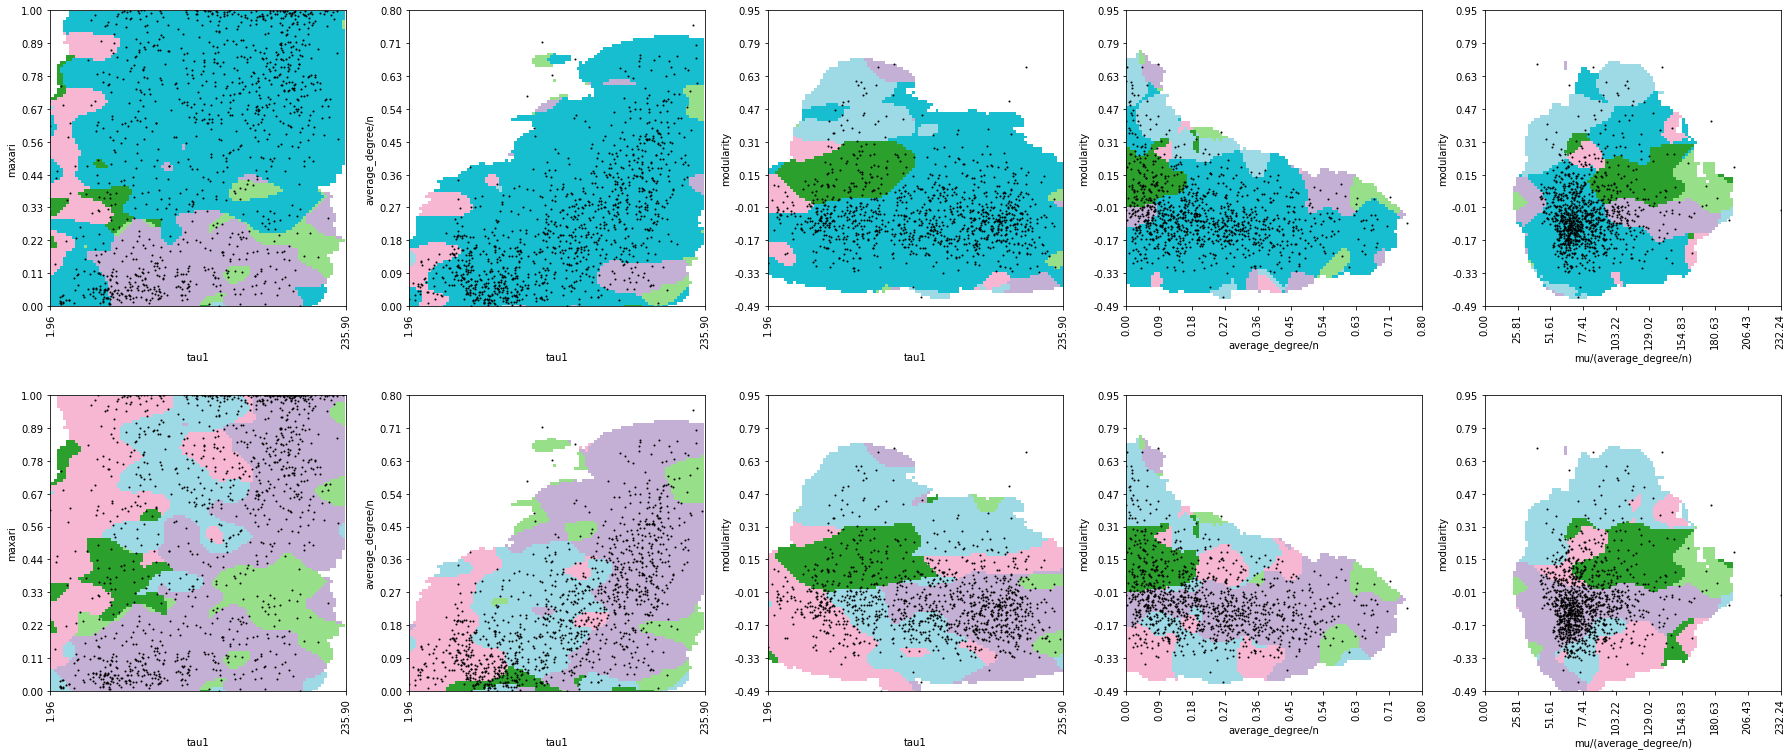

In [66]:
distance = 0.03

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['modularity', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['modularity', 'average_degree/n']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['modularity', 'mu/(average_degree/n)']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)


feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['modularity', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['modularity', 'average_degree/n']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['modularity', 'mu/(average_degree/n)']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

In [ ]:
features = ['tau1', 'modularity', 'average_degree/n']

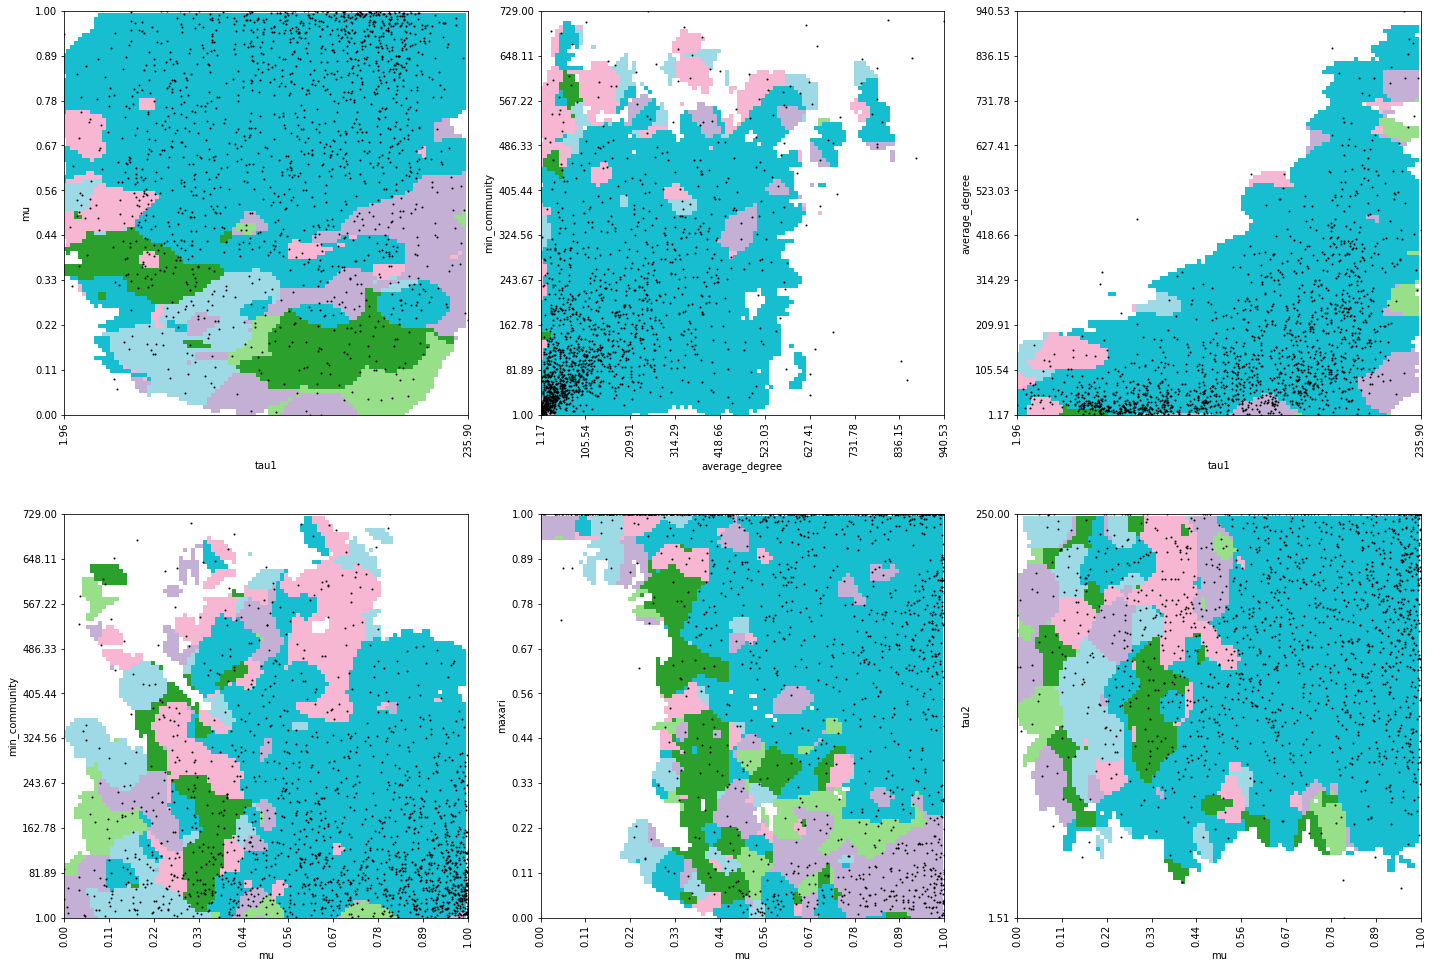

In [25]:
distance = 0.02

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['mu', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['min_community', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['min_community', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['tau2', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

plt.tight_layout()

In [26]:
def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            pixels_kernels_results[11] = 0
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

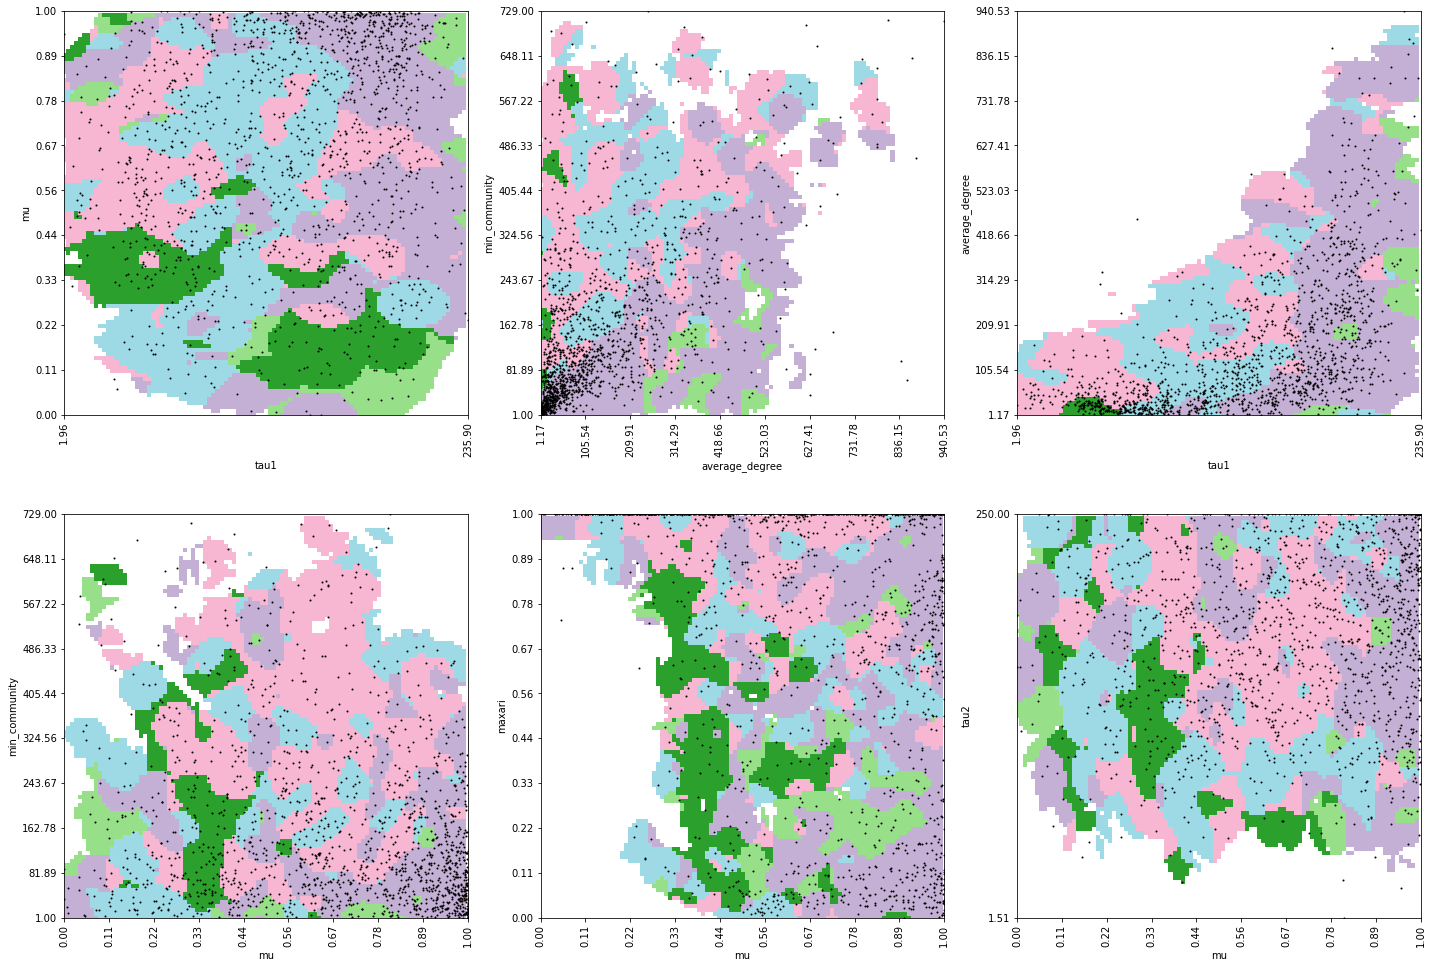

In [27]:
distance = 0.02

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['mu', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['min_community', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['min_community', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['tau2', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

plt.tight_layout()

In [28]:
def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            pixels_kernels_results[11] = 0
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

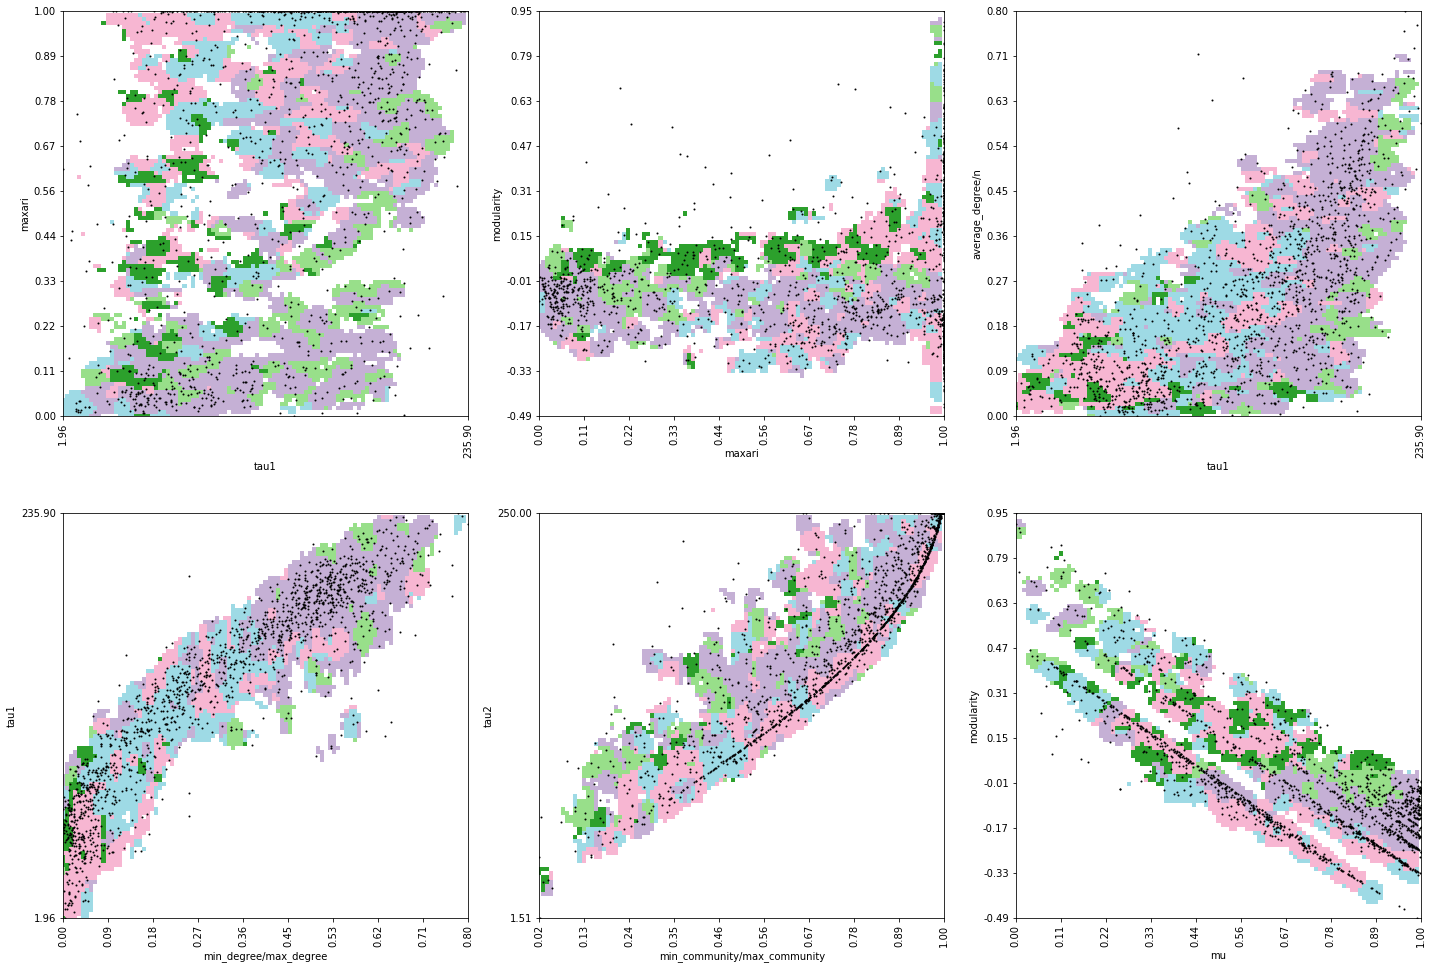

In [29]:
distance = 0.01

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['modularity', 'maxari']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)


feature_names = ['tau1', 'min_degree/max_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau2', 'min_community/max_community']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['modularity', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)


plt.tight_layout()

In [30]:
def prepare_plot_knn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([sorted(list(item[0].items())[:11] + list(item[0].items())[12:], key=lambda x: -x[1])[0][0] for item in dataset])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

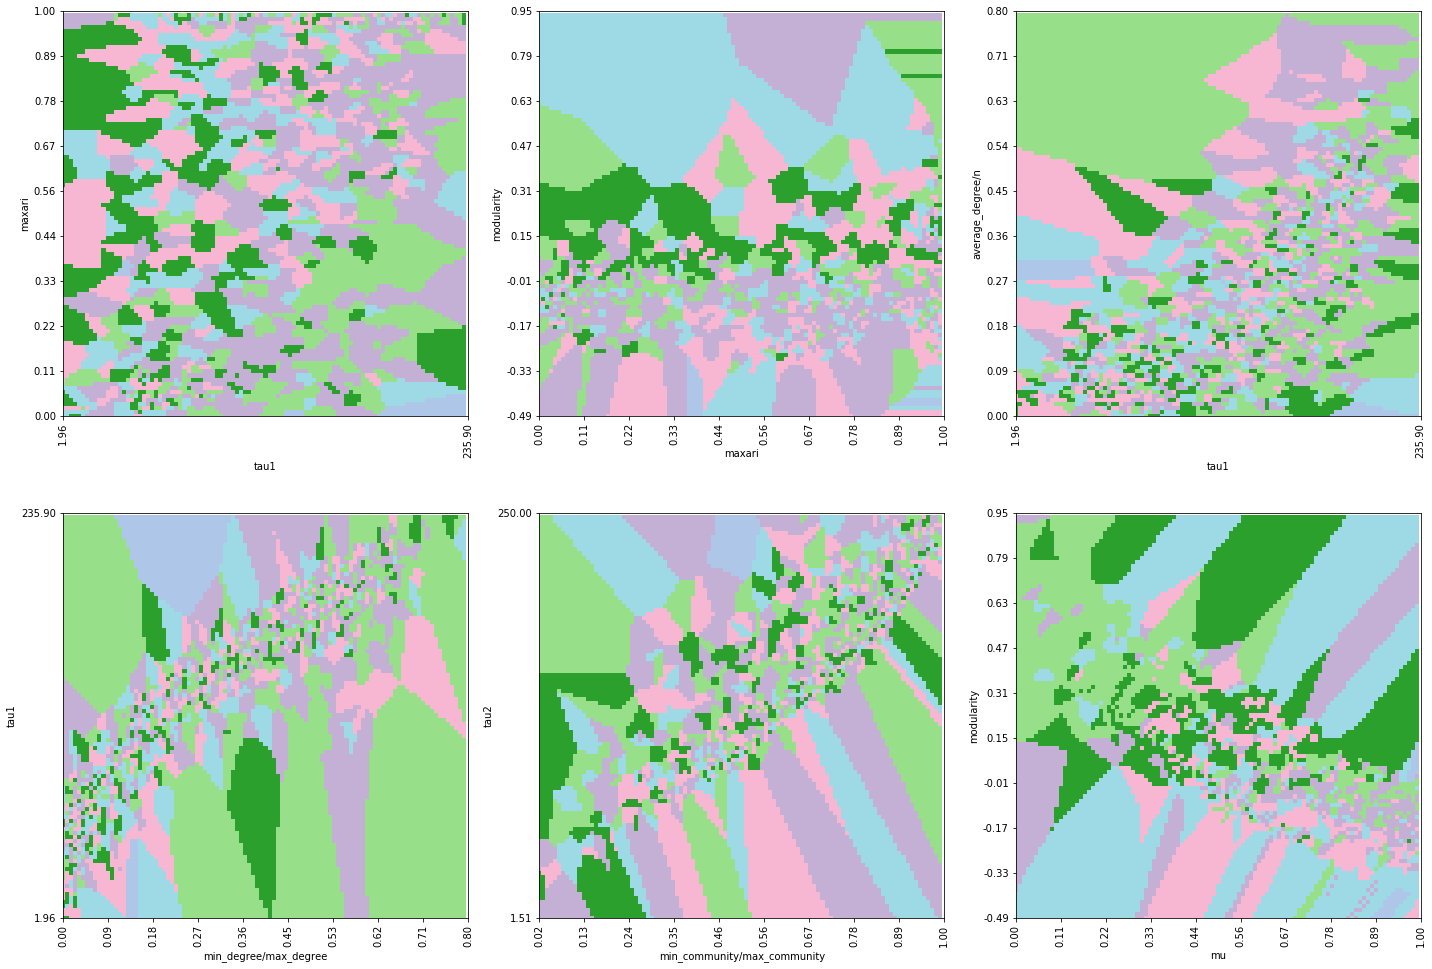

In [31]:
n_neighbors = 1

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][0], X, y, plot, feature_names, scatter=False)

feature_names = ['modularity', 'maxari']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][1], X, y, plot, feature_names, scatter=False)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][2], X, y, plot, feature_names, scatter=False)


feature_names = ['tau1', 'min_degree/max_degree']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][0], X, y, plot, feature_names, scatter=False)

feature_names = ['tau2', 'min_community/max_community']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][1], X, y, plot, feature_names, scatter=False)

feature_names = ['modularity', 'mu']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][2], X, y, plot, feature_names, scatter=False)


plt.tight_layout()

In [32]:
tx = np.array([[fnc[fname](item[1][fname]) for fname in all_feature_names] for item in dataset]).astype(np.float32)
ty = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset]).astype(np.float32)
tx.shape, ty.shape

((1528, 13), (1528, 25))

In [33]:
tx = tx[np.max(ty, axis=1) < 0.9999]
ty = ty[np.max(ty, axis=1) < 0.9999]
tx.shape, ty.shape

((1057, 13), (1057, 25))

# SCCT vs ALL
    'Katz': d3_category20[0],
    'logKatz': d3_category20[1],
    'For': d3_category20[2],
    'logFor': d3_category20[3],
    'Comm': d3_category20[4],
    'logComm': d3_category20[5],
    'Heat': d3_category20[6],
    'logHeat': d3_category20[7],
    'NHeat': d3_category20[8],
    'logNHeat': d3_category20[9],
    'SCT': d3_category20[10],
    'SCCT': d3_category20[11],
    'RSP': d3_category20[12],
    'FE': d3_category20[13],
    'PPR': d3_category20[14],
    'logPPR': d3_category20[15],
    'ModifPPR': d3_category20[16],
    'logModifPPR': d3_category20[17],
    'HeatPR': d3_category20[18],
    'logHeatPR': d3_category20[19],
    'DF': d3_category20[20],
    'logDF': d3_category20[21],
    'Abs': d3_category20[22],
    'logAbs': d3_category20[23],
    'SP-CT': d3_category20[24],
    
    'n', 0
    'k', 1
    'tau1', 2
    'tau2', 3
    'mu', 4
    'average_degree', 5
    'min_community', 6
    'maxari', 7
    'modularity', 8
    'average_degree/n', 9
    'min_community/max_community', 10
    'min_degree/max_degree', 11

In [34]:
class RFE:
    def __init__(self, estimator, names, max_features=5, n_jobs=None):
        self.estimator = estimator
        self.names = names
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.results = {}

    @ignore_warnings(category=ConvergenceWarning)
    def score_one(self, x, y, weights, set_feat_names):
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)

        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        return set_feat_names, f1, estimator

    def fit(self, x, y, weights):
        # for all features first:
        _, f1_all, estimator_all = self.score_one(x, y, weights, self.names)
        print(f'all features, f1={f1_all:.3f}')

        for n_features in range(1, self.max_features + 1):
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.score_one)(x, y, weights, set_feat_names)
                for set_feat_names in tqdm(list(combinations(self.names, n_features))))
            best_n_feat, best_f1, best_estimator = None, 0, None
            for set_feat_names, f1, estimator in results:
                if f1 > best_f1:
                    best_n_feat, best_f1, best_estimator = set_feat_names, f1, estimator
            print(f'{n_features} features, f1={best_f1:.3f}, set={best_n_feat}')
            if hasattr(best_estimator, 'best_params_'):
                print(best_estimator.best_params_)
            self.results[n_features] = {
                'f1': best_f1,
                'set': best_n_feat
            }

        return self

    def draw1d(self, x, y, weights):
        set_feat_names = self.results[1]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(1, 2, figsize=(16, 3))
        ax[0].scatter(x[:, support_idx[0]], [np.random.rand() for _ in range(x.shape[0])], c=ty_bool)
        ax[0].set_title('gt')
        ax[1].scatter(x[:, support_idx[0]], [np.random.rand() for _ in range(x.shape[0])], c=y_pred)
        ax[1].set_title('preds')

        ax[0].set_xlabel(set_feat_names[0])
        ax[1].set_xlabel(set_feat_names[0])

        plt.tight_layout()
    
    def draw2d(self, x, y, weights):
        set_feat_names = self.results[2]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0].set_title('gt')
        ax[1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[1].set_title('preds')

        ax[0].set_xlabel(set_feat_names[0])
        ax[1].set_xlabel(set_feat_names[0])
        ax[0].set_ylabel(set_feat_names[1])
        ax[1].set_ylabel(set_feat_names[1])

        plt.tight_layout()
        
    def draw3d(self, x, y, weights):
        set_feat_names = self.results[3]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(2, 2, figsize=(16, 16))
        ax[0][0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0][0].set_title('gt')
        ax[0][1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[0][1].set_title('preds')

        ax[0][0].set_xlabel(set_feat_names[0])
        ax[0][1].set_xlabel(set_feat_names[0])
        ax[0][0].set_ylabel(set_feat_names[1])
        ax[0][1].set_ylabel(set_feat_names[1])
        
        ax[1][0].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=ty_bool)
        ax[1][0].set_title('gt')
        ax[1][1].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=y_pred)
        ax[1][1].set_title('preds')

        ax[1][0].set_xlabel(set_feat_names[1])
        ax[1][1].set_xlabel(set_feat_names[1])
        ax[1][0].set_ylabel(set_feat_names[2])
        ax[1][1].set_ylabel(set_feat_names[2])

        plt.tight_layout()
        
    def draw4d(self, x, y, weights):
        set_feat_names = self.results[4]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(3, 2, figsize=(16, 24))
        ax[0][0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0][0].set_title('gt')
        ax[0][1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[0][1].set_title('preds')

        ax[0][0].set_xlabel(set_feat_names[0])
        ax[0][1].set_xlabel(set_feat_names[0])
        ax[0][0].set_ylabel(set_feat_names[1])
        ax[0][1].set_ylabel(set_feat_names[1])
        
        ax[1][0].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=ty_bool)
        ax[1][0].set_title('gt')
        ax[1][1].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=y_pred)
        ax[1][1].set_title('preds')

        ax[1][0].set_xlabel(set_feat_names[1])
        ax[1][1].set_xlabel(set_feat_names[1])
        ax[1][0].set_ylabel(set_feat_names[2])
        ax[1][1].set_ylabel(set_feat_names[2])

        ax[2][0].scatter(x[:, support_idx[2]], x[:, support_idx[3]], c=ty_bool)
        ax[2][0].set_title('gt')
        ax[2][1].scatter(x[:, support_idx[2]], x[:, support_idx[3]], c=y_pred)
        ax[2][1].set_title('preds')

        ax[2][0].set_xlabel(set_feat_names[2])
        ax[2][1].set_xlabel(set_feat_names[2])
        ax[2][0].set_ylabel(set_feat_names[3])
        ax[2][1].set_ylabel(set_feat_names[3])

        plt.tight_layout()

# SCCT

In [35]:
measure_idx = 11
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((ty[:, :measure_idx], ty[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**10
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(np.sum(ty_bool))

rfe = RFE(SVC(probability=True), all_feature_names, max_features=5)
rfe.fit(tx, ty_bool, None)

530
all features, f1=0.806



1 features, f1=0.745, set=('maxari',)



2 features, f1=0.763, set=('maxari', 'modularity')


KeyboardInterrupt: 

In [ ]:
rfe.draw1d(tx, ty_bool, None)

# NHeat

In [ ]:
measure_idx = 8
tywo11 = np.concatenate((ty[:, :11], ty[:, 12:]), axis=1)
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**100
lose_weights = np.abs(ari_measure - ari_other) * 7
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(np.sum(ty_bool))

rfe = RFE(SVC(probability=True), all_feature_names[:1] + all_feature_names[2:], max_features=5)
rfe.fit(tx, ty_bool[:, (0, 2, 3, 4, 5, 6, 7, 8)], None)  # weights

In [ ]:
rfe.draw2d(tx, ty_bool, None)  # weights

# NHeat

In [ ]:
measure_idx = 8
tywo11 = np.concatenate((ty[:, :11], ty[:, 12:]), axis=1)
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**100
lose_weights = np.abs(ari_measure - ari_other) * 7
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(np.sum(ty_bool))

rfe = RFE(SVC(probability=True), all_feature_names[:1] + all_feature_names[2:], max_features=5)
rfe.fit(tx, ty_bool[:, (0, 2, 3, 4, 5, 6, 7, 8)], None)  # weights

In [ ]:
rfe.draw2d(tx, ty_bool, None)  # weights

# Comm

In [ ]:
measure_idx = 4
tywo11 = np.concatenate((ty[:, :11], ty[:, 12:]), axis=1)
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**200
lose_weights = np.abs(ari_measure - ari_other) * 5
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(np.sum(ty_bool))

rfe = RFE(GaussianMixture(n_components=2), all_feature_names, max_features=5)
rfe.fit(tx, ty_bool, None)  # weights

In [ ]:
rfe.draw3d(tx, ty_bool, None)  # weights

# RSP

In [ ]:
measure_idx = 12
tywo11 = np.concatenate((ty[:, :11], ty[:, 12:]), axis=1)
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx-1], tywo11[:, measure_idx+1-1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**200
lose_weights = np.abs(ari_measure - ari_other)
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(np.sum(ty_bool))

rfe = RFE(GaussianMixture(n_components=2), all_feature_names, max_features=5)
rfe.fit(tx, ty_bool, None)  # weights

In [ ]:
rfe.draw4d(tx, ty_bool, None)  # weights

# logComm

In [ ]:
measure_idx = 5
tywo11 = np.concatenate((ty[:, :11], ty[:, 12:]), axis=1)
ari_measure, ari_other = ty[:, measure_idx], np.max(np.concatenate((tywo11[:, :measure_idx], tywo11[:, measure_idx+1:]), axis=1), axis=1)
win_weights = 1 / np.sum(ty == np.max(ty, axis=1, keepdims=True), axis=1)**200
lose_weights = np.abs(ari_measure - ari_other)
weights = [ww if ari_m >= ari_o else lw for ari_m, ari_o, ww, lw in zip(ari_measure, ari_other, win_weights, lose_weights)]

ty_bool = ari_measure >= ari_other
print(np.sum(ty_bool))

rfe = RFE(GaussianMixture(n_components=2), all_feature_names, max_features=5)
rfe.fit(tx, ty_bool, None)  # weights

In [ ]:
rfe.draw3d(tx, ty_bool, None)  # weights